In [1]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [2]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [3]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [5]:
# IMPORTING DATASET 
dataset = pd.read_csv(r'C:\Users\DELL PC\Desktop\DV Review 3\Stock Price Data Companies\RAMCOSYS.NS.csv', usecols=[1,2,3,4])

In [6]:
dataset

,Open,High,Low,Close
0,125.847000,134.427002,125.847000,133.854996
1,133.951004,135.380997,133.473999,134.188995
2,133.951004,138.192993,133.473999,135.667007
3,NaN,NaN,NaN,NaN
4,137.143997,138.908005,131.567001,133.522003
...,...,...,...,...
4527,528.400024,532.700012,504.000000,507.950012
4528,511.000000,514.950012,484.000000,491.049988
4529,491.500000,500.000000,466.500000,470.149994
4530,473.000000,476.799988,449.000000,453.299988


In [7]:
print('Before dropping:\n', dataset.isna().sum(), sep = '')
dataset.dropna(axis = 0, how = 'any', inplace = True)
print('\nAfter dropping:\n', dataset.isna().sum(), sep = '')

Before dropping:
Open     104
High     104
Low      104
Close    104
dtype: int64

After dropping:
Open     0
High     0
Low      0
Close    0
dtype: int64


In [8]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

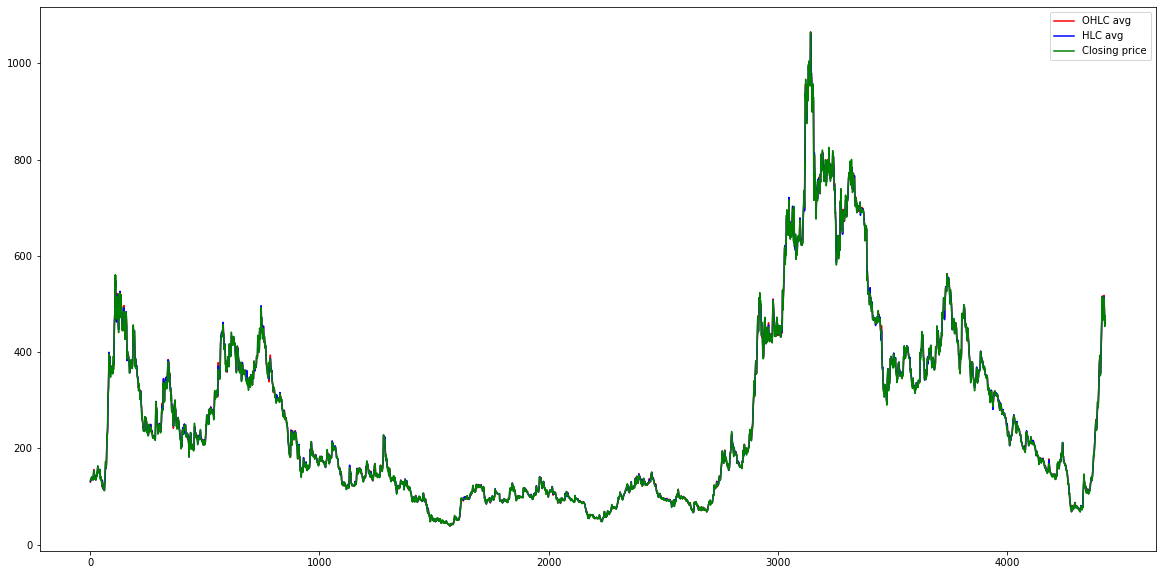

In [9]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.figure(figsize=(20,10))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [10]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [11]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [12]:
trainX ## 100 -> 80 20 -> 

array([[[0.08864986]],

       [[0.09279524]],

       [[0.09384018]],

       ...,

       [[0.72577223]],

       [[0.72197248]],

       [[0.71674781]]])

In [13]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!

In [14]:
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
3319/3319 - 5s - loss: 0.0034
Epoch 2/10
3319/3319 - 6s - loss: 1.3644e-04
Epoch 3/10
3319/3319 - 5s - loss: 1.4194e-04
Epoch 4/10
3319/3319 - 5s - loss: 1.4275e-04
Epoch 5/10
3319/3319 - 6s - loss: 1.3146e-04
Epoch 6/10
3319/3319 - 6s - loss: 1.4133e-04
Epoch 7/10
3319/3319 - 5s - loss: 1.3169e-04
Epoch 8/10
3319/3319 - 4s - loss: 1.2534e-04
Epoch 9/10
3319/3319 - 5s - loss: 1.2993e-04
Epoch 10/10
3319/3319 - 6s - loss: 1.3353e-04


In [15]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [16]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [17]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 9.25


In [18]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 8.47


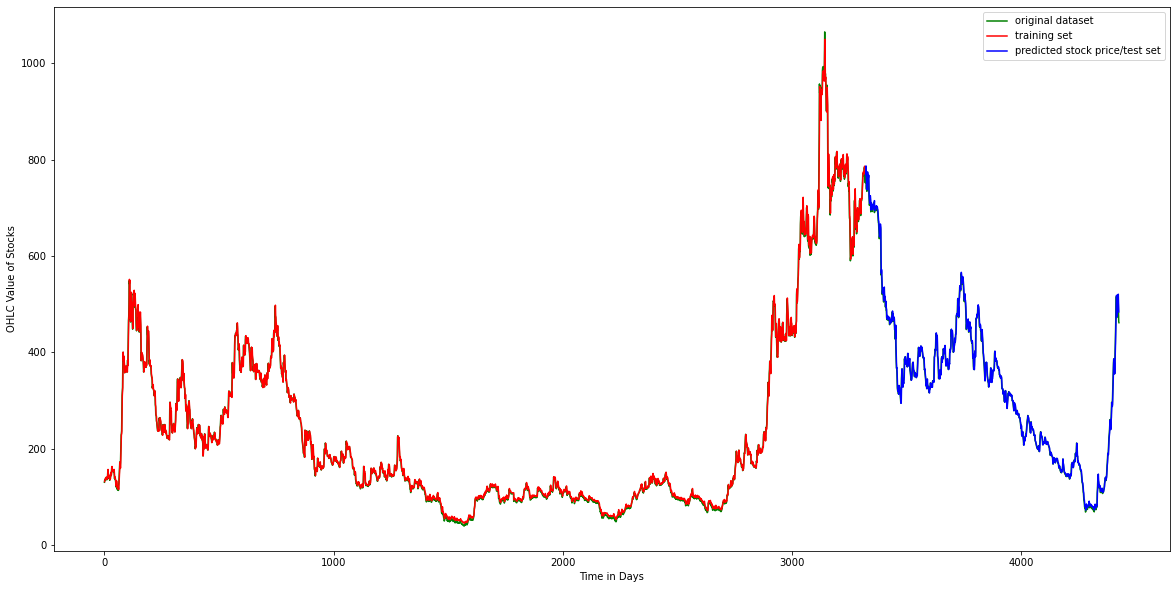

In [19]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(20,10))
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Stocks')
plt.show()

In [20]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Day Value: 483.8246765136719
Next Day Value: 476.5802001953125


<ipython-input-20-07399bf6cb21>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Last Day Value:", np.asscalar(last_val))
<ipython-input-20-07399bf6cb21>:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print("Next Day Value:", np.asscalar(last_val*next_val))


In [ ]:
## 477.7